In [1]:
# 导入环境的包
import time
import sys
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt  # this is used for the plot the graph
import seaborn as sns  # used for plot interactive graph.
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters

## keras
from tcn import TCN
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential

In [2]:
# config matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 30, 10
register_matplotlib_converters()

In [3]:
#将序列转为监督学习序列数据
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
daily_cases_ = pd.read_csv('../new_daily_cases/new_daily_cases_China.csv').iloc[:,1:]
df_resample=daily_cases_.T
df_resample

,0
1/23/20,0.0
1/24/20,0.0
1/25/20,0.0
1/26/20,0.0
1/27/20,0.0
...,...
5/10/22,7895.0
5/11/22,7357.0
5/12/22,7118.0
5/13/22,6768.0


In [5]:
## * Note: 归一化数据范围为0-1.

values = df_resample.values 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# 数据转为监督学习数据，time-step=1
reframed = series_to_supervised(scaled, 1, 1)

In [6]:
# 划分数据集
values = reframed.values
#https://easy-station.taobao.com/
#一般训练数据集以总数据的*0.7，测试数据以总数据的*0.3，
train = values[400:-7, :]
test = values[-7:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# 构建数据的3D 格式，即[samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
test_y

(435, 1, 1) (435,) (7, 1, 1) (7,)


array([0.18285159, 0.17188859, 0.15969174, 0.14880964, 0.1439754 ,
       0.13689597, 0.1255082 ])

# 构建TCN

### 1) TCN 卷积个数32，卷积核3等
### 2) dropout 层20%
### 3) 1个神经元在输出层中
### 4) 输入形状为1个时间步长，有7个特征

### 5)使用了平均绝对误差（MAE）损失函数和随机梯度下降的有效Adam。
### 6)  epochs=100, batch size = 10.

In [7]:
time_start = time.time()  # 记录开始时间

#网络模型
model = Sequential()
model.add(TCN(nb_filters=32,kernel_size=3,padding='causal', dilations=(1, 2, 4, 8,16), input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=8, validation_data=(test_X, test_y), verbose=2, shuffle=False)

time_end = time.time()  # 记录结束时间
time_sum = time_end - time_start  # 计算的时间差为程序的执行时间，单位为秒/s
print("train time:",time_sum)


# 显示训练的loss值情况
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss in TCN')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
# plt.show()

time_start = time.time()  # 记录开始时间

# 做预测
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 1))
# i反归一化预测值
inv_yhat = np.concatenate((yhat, test_X[:,:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# 反归一化真实值
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:,:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

time_end = time.time()  # 记录结束时间
time_sum = time_end - time_start  # 计算的时间差为程序的执行时间，单位为秒/s
print("predict time:",time_sum)

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.4f' % rmse)

Epoch 1/100
55/55 - 3s - loss: 0.0974 - val_loss: 6.8982e-04
Epoch 2/100
55/55 - 0s - loss: 0.0361 - val_loss: 0.0012
Epoch 3/100
55/55 - 0s - loss: 0.0526 - val_loss: 0.0010
Epoch 4/100
55/55 - 0s - loss: 0.0142 - val_loss: 0.0068
Epoch 5/100
55/55 - 0s - loss: 0.0142 - val_loss: 9.2634e-04
Epoch 6/100
55/55 - 0s - loss: 0.0103 - val_loss: 0.0026
Epoch 7/100
55/55 - 0s - loss: 0.0124 - val_loss: 8.9662e-05
Epoch 8/100
55/55 - 0s - loss: 0.0115 - val_loss: 0.0050
Epoch 9/100
55/55 - 0s - loss: 0.0077 - val_loss: 1.1558e-05
Epoch 10/100
55/55 - 0s - loss: 0.0085 - val_loss: 0.0013
Epoch 11/100
55/55 - 0s - loss: 0.0049 - val_loss: 4.1476e-04
Epoch 12/100
55/55 - 0s - loss: 0.0058 - val_loss: 4.6050e-04
Epoch 13/100
55/55 - 0s - loss: 0.0034 - val_loss: 2.6320e-04
Epoch 14/100
55/55 - 0s - loss: 0.0062 - val_loss: 9.5879e-04
Epoch 15/100
55/55 - 0s - loss: 0.0058 - val_loss: 2.7195e-04
Epoch 16/100
55/55 - 0s - loss: 0.0063 - val_loss: 0.0021
Epoch 17/100
55/55 - 0s - loss: 0.0068 - val_

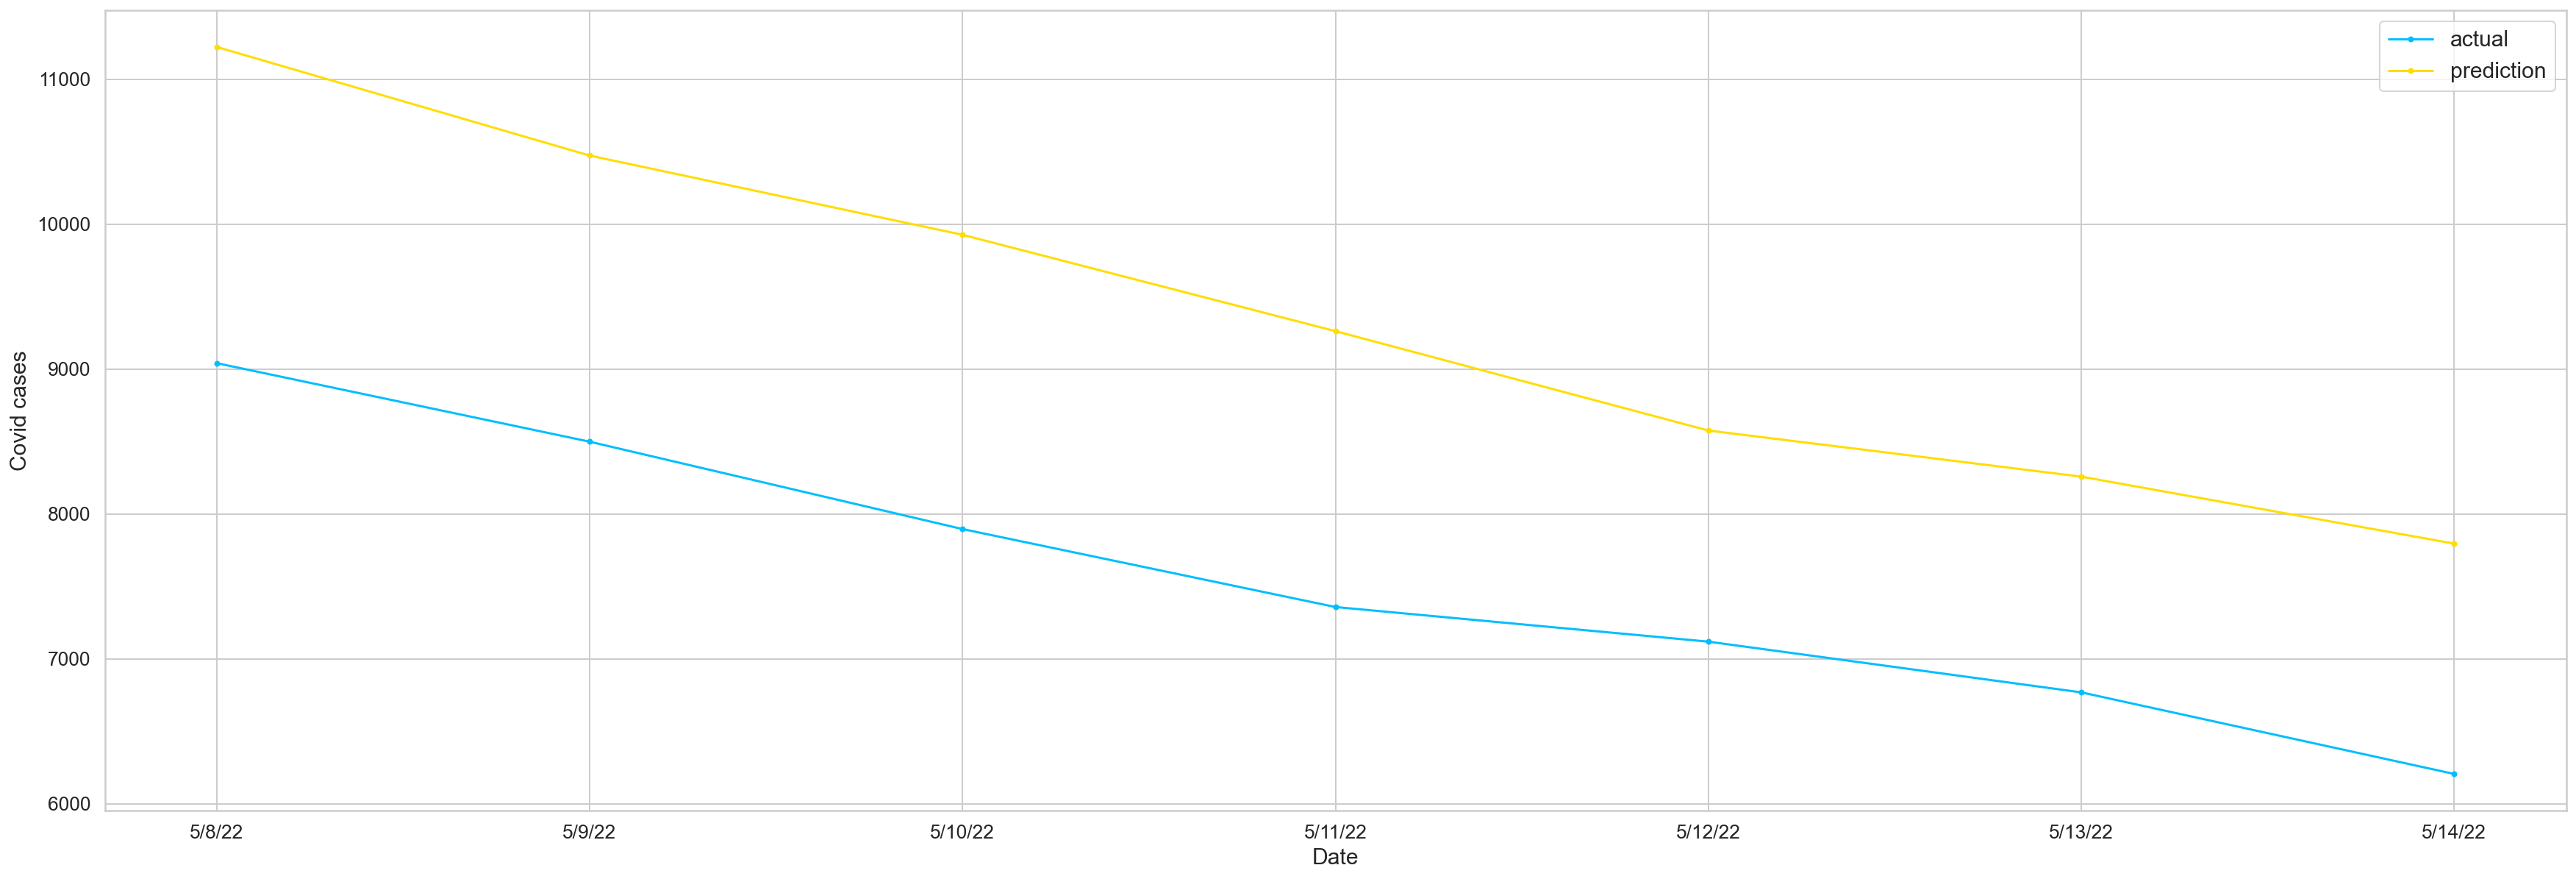

In [8]:
# 显示预测结果
plt.plot(df_resample.index[-7:], inv_y[-7:], marker='.', label="actual")
plt.plot(df_resample.index[-7:], inv_yhat[:],  marker='.',label="prediction")
plt.ylabel('Covid cases', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=15)
plt.show()

In [9]:
true_cases=inv_y
predicted_cases=inv_yhat
predicted_cases.astype(int)

array([11222, 10472,  9925,  9260,  8575,  8256,  7794])

In [10]:

# MSE = np.linalg.norm(true_cases-predicted_cases, ord=2)**2/len(true_cases)

RMSE = np.linalg.norm(true_cases-predicted_cases, ord=2)/len(true_cases)**0.5

NRMSE=RMSE/(np.max(true_cases)-np.min(true_cases))

# MAE = np.linalg.norm(true_cases-predicted_cases, ord=1)/len(true_cases)

MAPE=100 * np.mean(np.abs(true_cases-predicted_cases)) / np.mean(true_cases) 

SMAPE=200 * np.mean(np.abs(true_cases-predicted_cases) / (np.abs(true_cases) + np.abs(predicted_cases))) 


RMSE = round(RMSE,4)

NRMSE = round(NRMSE,4)

MAPE = round(MAPE,4)

SMAPE = round(SMAPE,4)

summary=[RMSE,NRMSE,MAPE,SMAPE]

summary

[1823.4214, 0.6432, 23.8769, 21.3075]

In [11]:
history.history['loss']

[0.09740017354488373,
 0.036096200346946716,
 0.052575625479221344,
 0.01417472306638956,
 0.014207598753273487,
 0.010298797860741615,
 0.012438291683793068,
 0.011540437117218971,
 0.007675501052290201,
 0.008477010764181614,
 0.00488797714933753,
 0.005846196785569191,
 0.0033570548985153437,
 0.006210566498339176,
 0.005781359970569611,
 0.006293957587331533,
 0.006794000044465065,
 0.004675824195146561,
 0.005545020569115877,
 0.0035627661272883415,
 0.004023315850645304,
 0.004169948864728212,
 0.00652339169755578,
 0.003973769955337048,
 0.0030354910995811224,
 0.0034948959946632385,
 0.003539110068231821,
 0.004417880438268185,
 0.004721132572740316,
 0.0044011385180056095,
 0.0028271209448575974,
 0.002488560276106,
 0.0026693488471210003,
 0.0033009673934429884,
 0.0032804650254547596,
 0.003475775709375739,
 0.004071424715220928,
 0.00503879738971591,
 0.004611161071807146,
 0.004951263312250376,
 0.00484555633738637,
 0.005539142061024904,
 0.0036224625073373318,
 0.0033752

In [12]:
history.history['val_loss']

[0.0006898161373101175,
 0.0011506130686029792,
 0.0010098947677761316,
 0.006779801566153765,
 0.0009263361571356654,
 0.0025601577945053577,
 8.9661953097675e-05,
 0.004957940895110369,
 1.1557559446373489e-05,
 0.0012987341033294797,
 0.00041476418846286833,
 0.0004605048743542284,
 0.00026320337201468647,
 0.0009587944368831813,
 0.00027194980066269636,
 0.0021229933481663465,
 0.00037123498623259366,
 0.00306028313934803,
 0.0012142449850216508,
 0.0007503302185796201,
 0.0011234433623030782,
 0.0009846868924796581,
 0.0005397585919126868,
 0.001096805790439248,
 0.00031628189026378095,
 0.0013547355774790049,
 0.0010563078103587031,
 0.001566886669024825,
 1.2323405826464295e-05,
 0.0016969208372756839,
 0.0010707371402531862,
 0.0010161648970097303,
 0.000989048508927226,
 0.001379324123263359,
 0.0009267967543564737,
 0.0019730909261852503,
 0.0005794273456558585,
 0.0025071531999856234,
 0.0001237324468092993,
 0.0010339765576645732,
 0.0003825711028184742,
 0.0021559293381869